# Data exploration

In [2]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

import keras
print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(100)
print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functions import MAE, RMSE, split_dataset

Using TensorFlow backend.


keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [3]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

In [4]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_scaled_train.pkl")
df_valid = pd.read_pickle(path + "df_scaled_valid.pkl")
df_test = pd.read_pickle(path + "df_scaled_test.pkl")

USE_DUMMY_DATA = False
if USE_DUMMY_DATA: 
    num_obs = 5000  # 5000, 10000 or 25000
    path = ROOT_PATH + "data/dummy/"
    df_train = pd.read_pickle(path + "dummy_train_{0}.pkl".format(num_obs))
    df_valid = pd.read_pickle(path + "dummy_valid_{0}.pkl".format(num_obs))
    df_test = pd.read_pickle(path + "dummy_test_{0}.pkl".format(num_obs))

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

# timestamps
ts = np.load(path + "timestamps/dtimestamps.npy")
ts_train = np.load(path + "timestamps/ts_train.npy")
ts_valid = np.load(path + "timestamps/ts_valid.npy")
ts_test = np.load(path + "timestamps/ts_test.npy")

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53210, 18) (53210, 3)


In [5]:
selected_features = [
   "VAL_23_ZT_92543:Z.X.Value",
   "VAL_23-PT-92523:X.Value",
   "VAL_23-PDT-92534:X.Value",
   "VAL_23_TT_92532:Z.X.Value",
   "VAL_23-TIC-92504:Z.X.Value",
   "VAL_23_KA_9101_M01_62C:Z.X.Value"
]

keep_idxs = [list(feature_tags).index(tag) for tag in selected_features]

x_train = x_train[:,keep_idxs]
x_valid = x_valid[:,keep_idxs]
x_test = x_test[:,keep_idxs]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53210, 6) (53210, 3)


In [14]:
print(keep_idxs)

train_selected = df_train.iloc[:,np.concatenate((range(3),sorted(keep_idxs)))]
train_val= df_valid.iloc[:,np.concatenate((range(3),sorted(keep_idxs)))]
valid_selected = df_valid.


## Plots and distributions

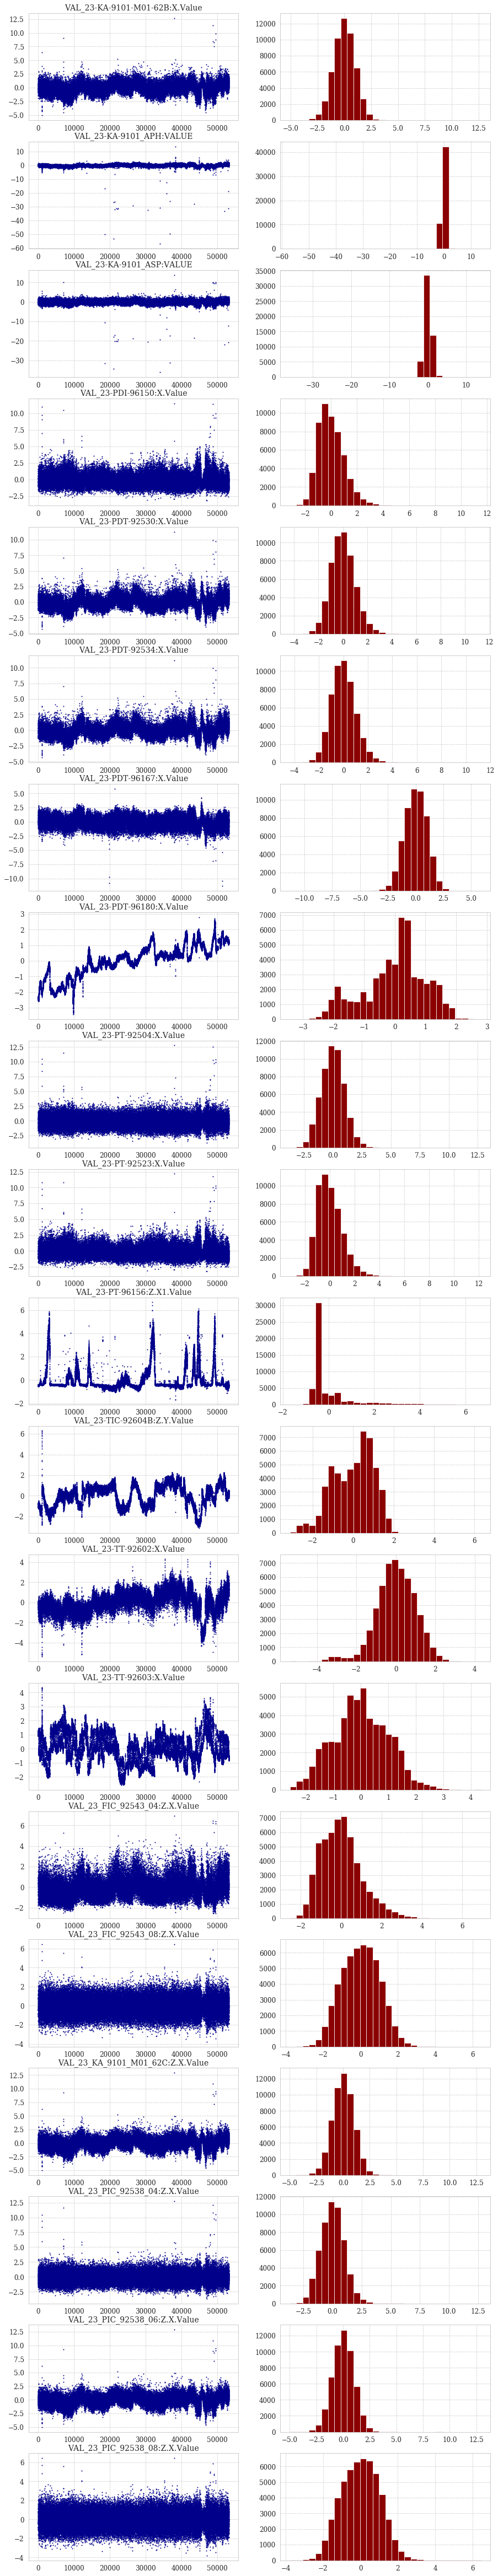

In [35]:
fig, axs = plt.subplots(nrows=train_selected.shape[-1], ncols=2, figsize=(15,85))

for figrow in range(train_selected.shape[-1]):
    ax1,ax2 = axs[figrow,0], axs[figrow,1]
    
    ax1.plot(X[:,f], color="darkblue", marker="o", markersize=1.0, lw=0)
    ax1.set_title(selected_tags["Tag"][f])
    
    ax2.hist(X[:,f], bins=30, color="darkred")
    f +=1

fig.show()

#### Autocorrelation

In [ ]:
selected_train.shape

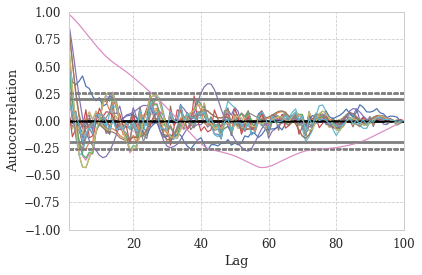

In [40]:
data = selected_train
tags = np.concatenate((target_tags, selected_tags["Tag"].values))

for target in range(len(selected_tags)):
    pd.plotting.autocorrelation_plot(pd.DataFrame(data[:100,target], columns=[tags[target]]))

#### Variable correlation

In [41]:
def plot_correlation(df, title="Correlation plot"):
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, linewidths=1, cbar_kws={"shrink": .6})

    ax.set_title(title)
    
    return f

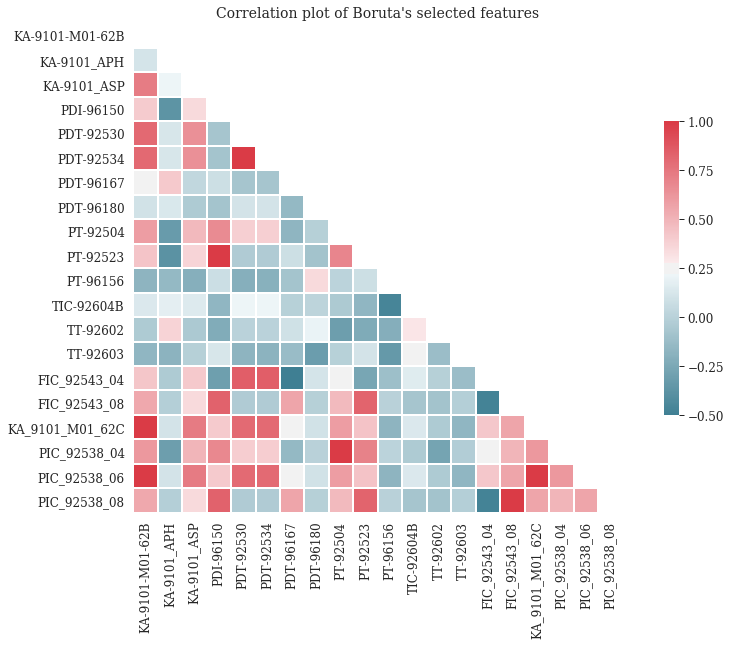

In [42]:
colnames = [name.split("VAL_23")[1][1:].split(":")[0] for name in selected_tags["Tag"]]
df = pd.DataFrame(selected_data[:,len(target_tags):], columns=colnames)

fig = plot_correlation(df, "Correlation plot of selected features")
fig.show()